In [1]:
#必要ライブラリのインポート

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, zipfile, io , re
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import  Conv2D,MaxPooling2D
from keras.layers.core import Dense,Dropout,Activation, Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.callbacks import  EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D,Input


Using TensorFlow backend.


データセットはここから
https://susanqq.github.io/UTKFace/

In [2]:
#データセットを変数に格納
image_size = 100 #入力画像のサイズ
z = zipfile.ZipFile('./UTKFace.zip') #ローカルでは解凍していたが重いのでzip

#[age]_[gender]_[race]_[date&time].jpg
imgfiles = [x for x in z.namelist() if re.search(r"^UTKFace.*jpg$",x)]

X = []
Y = []

for imgfiles in imgfiles:
  #バイナリからの読み込み
  image = Image.open(io.BytesIO(z.read(imgfiles)))
  #色の変換
  image = image.convert('RGB')
  #100×100に変換
  image = image.resize((image_size,image_size))
  data = np.asarray(image)
  file  =os.path.basename(imgfiles)
  #split()を用いてファイル名から年齢を取得する
  file_split = [ i for i in file.split('_')]
  X.append(data)
  Y.append(int(file_split[0]))
z.close()

X = np.array(X)
Y = np.array(Y)

del z, imgfiles #メモリの節約のため、用済みのリストを削除
print(X.shape,Y.shape)


(23708, 100, 100, 3) (23708,)


In [6]:

#検証用とテスト用のデータを分割する。
X_train , X_test , y_train , y_test = train_test_split(
    X,
    Y,
    random_state = 0,
    test_size = 0.2
)

del X,Y
print(X_train.shape , y_train.shape , X_test.shape, y_test.shape)

#学習用をさらに8:2で分割する。少ないほうが検証用
#データ型の変換、正規化
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train , X_val , y_train , y_val = train_test_split(
    X_train,
    y_train,
    random_state = 0,
    test_size  =0.2
)

print(X_train.shape,y_train.shape, X_val.shape,y_val.shape)

(18966, 100, 100, 3) (18966,) (4742, 100, 100, 3) (4742,)
(15172, 100, 100, 3) (15172,) (3794, 100, 100, 3) (3794,)


In [7]:
# #CNNモデルの構築⑥（VGG16を使用）
def model_train(X,y):
  vgg16_model = VGG16(
      #重みにImagenetを使用
      weights = 'imagenet',
      #全結合層を別途作成するので、Falseを指定
      include_top = False,
      input_shape = (100,100,3)
  )
  #全結合層の定義
  top_model = Sequential()
  top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))#1次元ベクトルに変換
  top_model.add(Dense(1))

  #モデルの結合
  model = Model(
      inputs = vgg16_model.input,
      outputs = top_model(vgg16_model.output)
      
  )
  #14層目まで重みを更新しない
  for layer in vgg16_model.layers[:15]:
    layer.trainable = False

  model.compile(loss='mse',optimizer='Adam',metrics=['mae'])#誤差関数は平均2乗誤差、最適化手法にはAdam、評価指標は平均絶対誤差


  return model


In [8]:
#学習過程を可視化するための関数
def plot_history(history):
  plt.plot(history.history['loss'],"o-",label="loss")
  plt.plot(history.history['val_loss'],"o-",label="val_loss")
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='upper right')
  plt.show



In [9]:
#Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center = False,#チャネルごとの画素置の平均を0にする
    samplewise_center = False,#サンプルごとの画素値の平均を0にする
    featurewise_std_normalization = False,#チャンネルごとの画素値の分散を1にする
    samplewise_std_normalization = False,#サンプルごとの分散を1にする
    zca_whitening = False,#白色化を行う
    rotation_range = 0,#回転させる
    width_shift_range = 0.1,#左右に平行移動する
    height_shift_range = 0.1,#上下に平行移動する
    horizontal_flip = True,#左右反転する
    vertical_flip = False#上下反転する

)

In [10]:
#コールバック関数の定義
#EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1
)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    verbose = 1
)



58892288/58889256 [==============================] - 36s 1us/step
Epoch 1/50
118/118 [==============================] - 52s 440ms/step - loss: 700.3922 - mae: 14.4776 - val_loss: 125.2966 - val_mae: 8.2499
Epoch 2/50
118/118 [==============================] - 38s 321ms/step - loss: 115.1758 - mae: 8.0238 - val_loss: 108.2036 - val_mae: 7.6330
Epoch 3/50
118/118 [==============================] - 37s 310ms/step - loss: 99.9819 - mae: 7.3392 - val_loss: 89.6661 - val_mae: 6.9124
Epoch 4/50
118/118 [==============================] - 36s 309ms/step - loss: 88.5679 - mae: 6.8859 - val_loss: 107.1124 - val_mae: 7.7997
Epoch 5/50
118/118 [==============================] - 37s 310ms/step - loss: 83.8321 - mae: 6.7060 - val_loss: 94.2669 - val_mae: 7.1446
Epoch 6/50
118/118 [==============================] - 37s 310ms/step - loss: 79.0100 - mae: 6.5152 - val_loss: 80.5151 - val_mae: 6.5220
Epoch 7/50
118/118 [==============================] - 37s 310ms/step - loss: 73.9645 - mae: 6.3358 - val_l

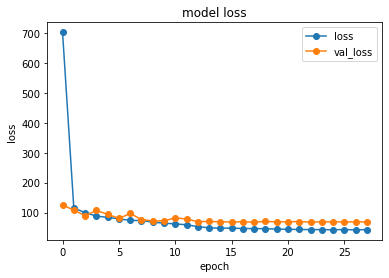

In [11]:
#学習の実行(GPUを使わないとかなり時間がかかる（3epochで30分くらいかかった...）)
model = model_train(X_train,y_train)
history = model.fit_generator(
    datagen.flow(X_train,y_train,batch_size=128),
    steps_per_epoch = X_train.shape[0] // 128,
    epochs = 50,
    validation_data = (X_val, y_val),
    callbacks = [early_stopping,reduce_lr],
    shuffle = True,
    verbose = 1
)
model.save('CNN.hdf5')
#plot_history(hist)
plot_history(history)

In [ ]:
#テストの実行
#モデルの読み込み
model = load_model('CNN.hdf5')

#testデータ30件の予測値
preds = model.predict(X_test[0:30])

#testデータ30件の画像と正解値と予測値を出力
plt.figure(figsize = (16,6))
#誤差の絶対値が5.0よりも大きい場合は赤字で表示する
for i in range(30):
  plt.subplot(3,10,i+1)
  plt.axis("off")
  pred = round(preds[i][0],1)
  true = y_test[i]
  #上が正解、下が予測値
  if abs(pred - true) < 5.0:
    plt.title(str(true) + '\n' + str(pred))
  else:
    plt.title(str(true) + '\n' + str(pred),color = "red")
  plt.imshow(X_test[i])
plt.show
